# Usage of the Imagine Model library

In this tutorial, we focus on introducing the model library and the IMAGINE built-in simulators as a building block of the IMAGINE package and how to use it for assembling a Bayesian analysis pipeline.  This example demonstrates the inference of some the parameter of the Jansson-Farrar magnetic field model using mock observations of pulsars in the Galaxy. 
Here, we intended to avoid the pitfalls of Galactic variance by assuming no magnetic field turbulence. For a more realistic example see 
[tutorial_wmap](https://github.com/IMAGINE-Consortium/imagine/blob/master/tutorials/tutorial_wmap.ipynb)
     

## 0) Preliminaries



### 0.a) First the imports and path settings

In [16]:
import imagine as img
from imagine.simulators.rmlos import RMSimulator
from imagine.fields.library.jf12 import JF12Regular
from imagine.fields.library.ymw16 import YMW16

import numpy as np
from astropy.coordinates import cartesian_to_spherical
import astropy.units as u
import os

# Directory paths
rundir = 'runs/mockdata'
figpath = 'figures/simulator_testing/'
logdir = 'log/'

os.system("rm -r runs/mockdata/*") # important, as multinest loads the previous piepline by default

dunit = u.rad/(u.m**2)


### 0.b) Defining some helper functions for the data generation

The following convenience functions wrap the generation of the mock data set (i.e. RMs, their errors and their position), and the set up of the corresponding IMAGINE observable dicts. 
The reader can skip this cell, for details see [tutorial_datasets](https://github.com/IMAGINE-Consortium/imagine/blob/master/tutorials/tutorial_datasets.ipynb). 

In [17]:
def produce_mock_data(field_list, mea, config, nd, noise=0.01):
    """Runs the simulator once to produce a simulated dataset"""
    test_sim = RMSimulator(measurements=mea, sim_config=config)
    simulation = test_sim(field_list)
    key = ('fd', None, 'tab', None)
    sim_data = simulation[key].data[0] * simulation[key].unit
    sim_data += np.random.normal(loc=0, scale=noise*abs(sim_data), size=nd)*simulation[key].unit
    return sim_data


def build_mock_data_and_config(nth, bfield, cart_grid, n_data):
        # Produce empty data format
    rm = np.zeros(n_data)*dunit  # placeholder
    rm_err = np.zeros(n_data)*dunit  # placeholder

    x = np.random.uniform(-0.9*cart_grid.box[0][0].value, 0.9*cart_grid.box[0][1].value, n_data)*u.kpc
    y = np.random.uniform(-0.9*cart_grid.box[1][0].value, 0.9*cart_grid.box[1][1].value, n_data)*u.kpc
    z = np.random.uniform(-0.1*cart_grid.box[2][0].value, 0.1*cart_grid.box[2][1].value, n_data)*u.kpc
    dist, lat, lon = cartesian_to_spherical(x+8.5*u.kpc, y, z)
    ph_data = {'fd': rm, 'err': rm_err, 'lat': lat, 'lon': lon}
    ph_data = img.observables.TabularDataset(ph_data,
                                               name='fd',
                                               units=dunit,
                                               data_col='fd',
                                               err_col='err',
                                               lat_col='lat',
                                               lon_col='lon')
    data_config =  img.observables.Measurements(ph_data)
    # Setup the Galactic field models


    # Setup observing configuration
    observer = np.array([-8.5, 0, 0])*u.kpc
    dist_err = dist/100000
    config = {'grid': cart_grid,
              'observer': observer,
              'dist': dist,
              'e_dist': dist_err,
              'lat': lat,
              'lon': lon,
              'FB': None}

    # Produce simulated dataset with noise
    noise_level = 0.01
    
    mock_data = produce_mock_data(field_list=[nth, bfield], mea=data_config, config=config, nd=n_data, noise=noise_level)
    
    
    mock_data = {'fd': mock_data, 'err': mock_data*noise_level, 'lat': config['lat'], 'lon': config['lon']}
    mock_data = img.observables.TabularDataset(mock_data,
                                               name='fd',
                                               units=dunit,
                                               data_col='fd',
                                               err_col='err',
                                               lat_col='lat',
                                               lon_col='lon')
    mock_data =  img.observables.Measurements(mock_data)

    
    return data_config, config, mock_data


## 1) Setting up the geometry

Here, we define the grid representing the Galaxy in a cartesian box.  This is done be providing the edges of the box, as well as the resolution.
For details see the [tutorial_fields](https://github.com/IMAGINE-Consortium/imagine/blob/master/tutorials/tutorial_fields.ipynb). 

In [18]:
n_data = 1000 # number of data points

xmax = 15*u.kpc  # size of the box
ymax = 15*u.kpc
zmax = 2*u.kpc

# setting up the 
cartesian_grid = img.fields.UniformGrid(box=[[-xmax, xmax], 
                                            [-ymax, ymax],
                                            [-zmax, zmax]],
                                    resolution=[30, 30, 30])  


## 2) Building the fields, mock data and likelihood

### 2.a) Building the fields

Here we define the models to be constrained in the inference run. We use the Jansson-Farrar magnetic fields model with default parameters and a constant thermal electron density. 

In [19]:

nth = img.fields.ConstantThermalElectrons(grid=cartesian_grid, parameters={'ne': 1*u.cm**(-3)})
# nth = YMW16(grid=cartesian_grid, parameters={'ne': 1*u.cm**(-3)})
bfield = JF12Regular(grid=cartesian_grid) # using default parameters




### 2.b) Building the Likelihood

We use the convenience functions defined above to generate mock data using the models defined before. 
We also define the simulator, i.e. the object that translates the magnetic field and thermal electron values into RM values at the sky positions they are observed.
For details on simulators see [tutorial_simulators](https://github.com/IMAGINE-Consortium/imagine/blob/master/tutorials/tutorial_simulators.ipynb).
The mock data is then used to define a simple (Gaussian) likelihood.

In [20]:

data_config, simulator_config, mock_data = build_mock_data_and_config(nth, bfield, cartesian_grid, n_data)    
# Setup simulator
los_simulator = RMSimulator(data_config, simulator_config)
# Initialize likelihood
likelihood = img.likelihoods.SimpleLikelihood(mock_data)



## 3) Building the Field Factories 

Field factories are IMAGINE objects which store the active parameters and the prior information on them. 
For details see [tutorial_prior](https://github.com/IMAGINE-Consortium/imagine/blob/master/tutorials/tutorial_prior.ipynb).

In [21]:

# Setup field factories and their active parameters
nth_factory = img.fields.FieldFactory(field_class=nth, grid=cartesian_grid)

B_factory   = img.fields.FieldFactory(field_class = bfield, grid=cartesian_grid)
B_factory.active_parameters = ('b_arm_1','b_arm_2', 
                               'b_arm_3','b_arm_4', 
                               )



B_factory.priors = {
'b_arm_1':img.priors.GaussianPrior(mu=0*u.microgauss, sigma=6*u.microgauss),
'b_arm_2':img.priors.GaussianPrior(mu=0*u.microgauss, sigma=6*u.microgauss),
'b_arm_3':img.priors.GaussianPrior(mu=0*u.microgauss, sigma=6*u.microgauss),
'b_arm_4':img.priors.GaussianPrior(mu=0*u.microgauss, sigma=6*u.microgauss),
}

factory_list = [B_factory, nth_factory]



## 4) Running the pipeline

At last, we evaluate our inference problem by running the Multinest sampler. 
Beware, that this pipeline may take several minutes up to half an hour depending on the hyper parameters chosen. 
One can steer the duration (and accuracy) of the pipeline by either increasing the evidence tolerance (i.e. the convergence criterion) or decreasing the live points (i.e. the resolution of the integration).
At last, a corner plot will be produced summarizing the results.


 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    4
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.999049
Replacements:                               1050
Total Samples:                              1051
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):   29224.189609 +/-  0.999524
Acceptance Rate:                        0.997280
Replacements:                               1100
Total Samples:                              1103
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):   29224.141317 +/-  0.999547
Acceptance Rate:                        0.996534
Replacements:                               1150



**Posterior report:**

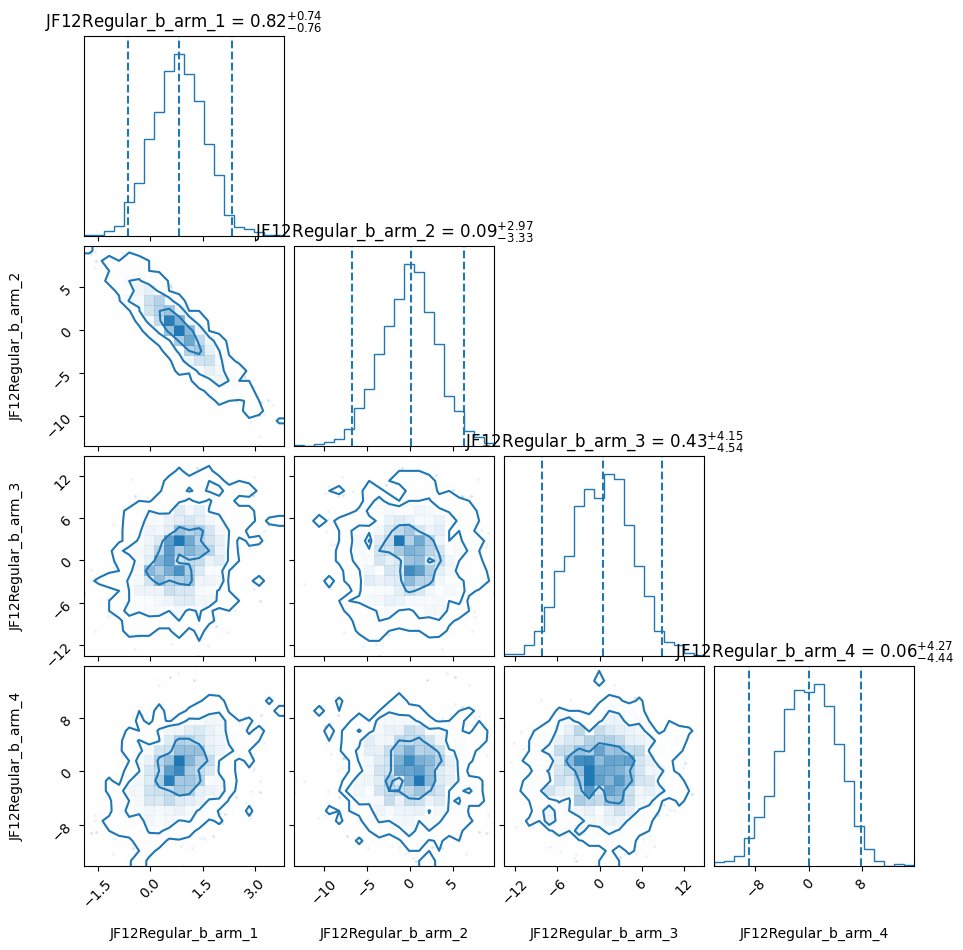

<IPython.core.display.Math object>

**Evidence report:**

<IPython.core.display.Math object>

In [22]:

pipeline = img.pipelines.MultinestPipeline(simulator=los_simulator,
                                            run_directory=rundir,
                                            factory_list=factory_list,
                                            likelihood=likelihood)
pipeline.sampling_controllers = {'evidence_tolerance': 0.05, 'n_live_points': 1000}

# Run!
results = pipeline()

summary = pipeline.posterior_summary
samples = pipeline.samples

